In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('fivethirtyeight')
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from keras.optimizers import Adamax
from sklearn.linear_model import LinearRegression

In [ ]:
end = datetime.now()
start = datetime(end.year-15,end.month,end.day)
stock = 'BTC-USD'
stock_data = yf.download(stock,start=start,end=end)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
stock_data.sample(10)
stock_data.describe()
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3869 entries, 2014-09-17 to 2025-04-20
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   3869 non-null   float64
 1   (High, BTC-USD)    3869 non-null   float64
 2   (Low, BTC-USD)     3869 non-null   float64
 3   (Open, BTC-USD)    3869 non-null   float64
 4   (Volume, BTC-USD)  3869 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 181.4 KB


In [ ]:
# close price data (because they are the most reliable indicator for stock trends and technical analysis.)
closing_price = stock_data[['Close']]
closing_price['Close']

Ticker,BTC-USD
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2025-04-16,84033.867188
2025-04-17,84895.750000
2025-04-18,84450.804688


<Axes: xlabel='Price-Ticker', ylabel='Price-Ticker'>

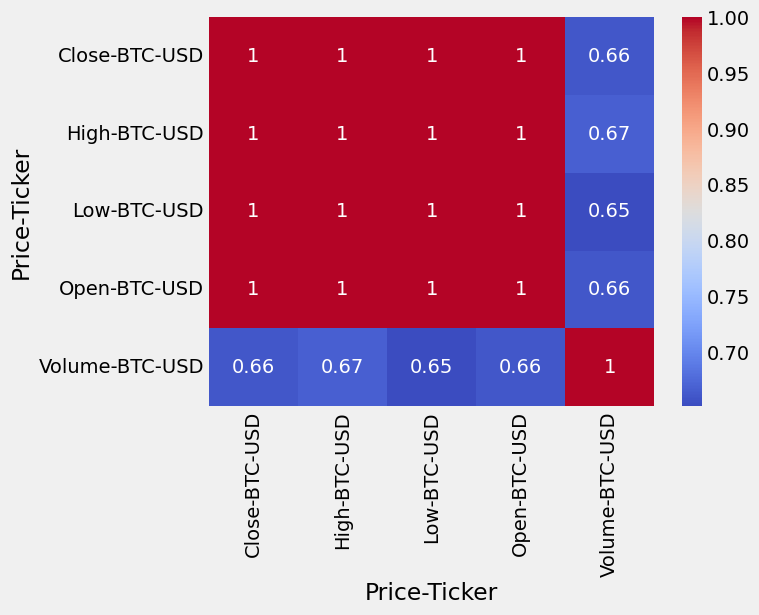

In [ ]:
import seaborn as sns
sns.heatmap(stock_data.corr(), annot=True, cmap='coolwarm')

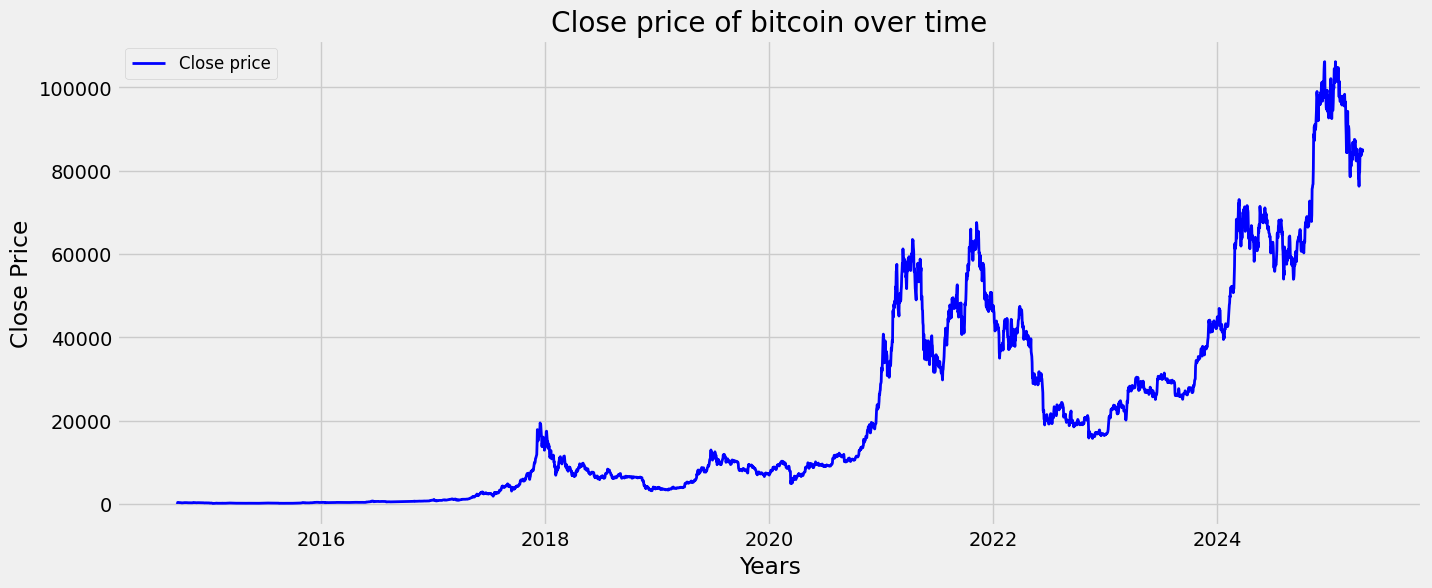

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(closing_price.index, closing_price['Close'], label = 'Close price', color='blue',linewidth=2)
plt.title("Close price of bitcoin over time")
plt.xlabel("Years")
plt.ylabel("Close Price")
# plt.grid(alpha = 0.3)
plt.legend(fontsize = 12)
plt.show()

In [ ]:
# Moving Average
for i in range(2014, 2024):
    print(i, list(stock_data.index.year).count(i))

closing_price['MA_365'] = closing_price['Close'].rolling(window = 365).mean()
closing_price['MA_100'] = closing_price['Close'].rolling(window = 100).mean()

2014 106
2015 365
2016 366
2017 365
2018 365
2019 365
2020 366
2021 365
2022 365
2023 365


<ipython-input-7-8eaa70400801>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closing_price['MA_365'] = closing_price['Close'].rolling(window = 365).mean()
<ipython-input-7-8eaa70400801>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closing_price['MA_100'] = closing_price['Close'].rolling(window = 100).mean()


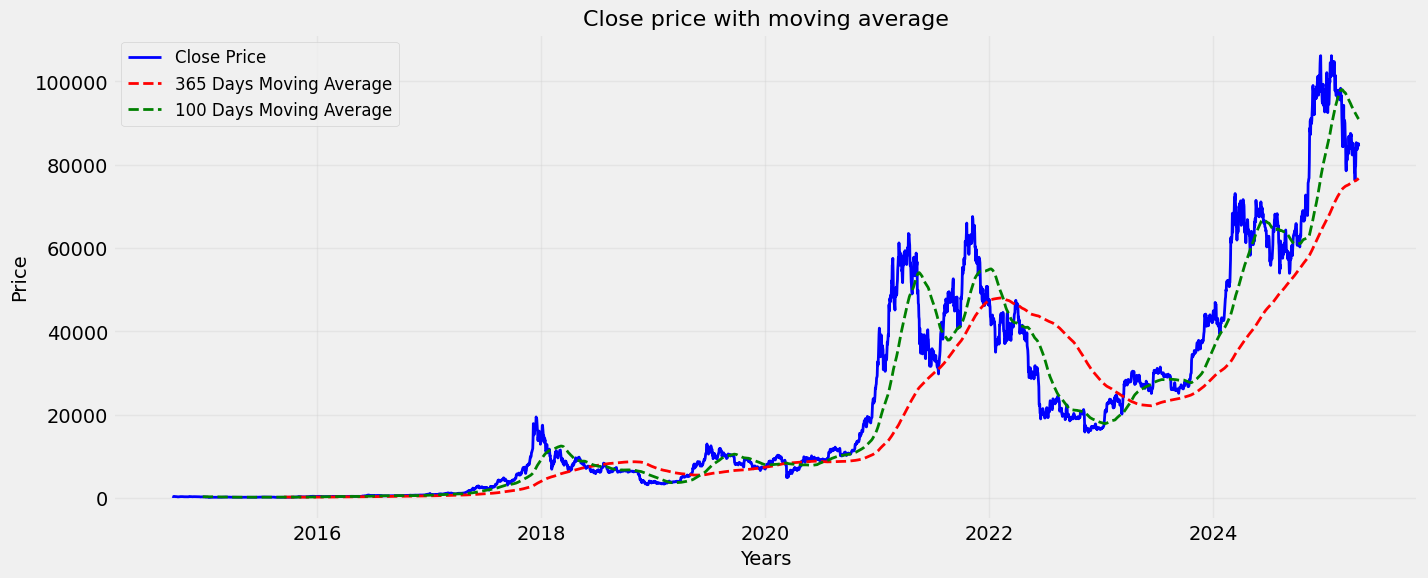

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(closing_price.index, closing_price['Close'], label = 'Close Price', color = 'blue', linewidth =2)
plt.plot(closing_price.index, closing_price['MA_365'], label = '365 Days Moving Average', color = 'red', linestyle ="--", linewidth =2)
plt.plot(closing_price.index, closing_price['MA_100'], label = '100 Days Moving Average', color = 'green',linestyle ="--", linewidth =2)

plt.title("Close price with moving average", fontsize = 16)
plt.xlabel("Years", fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.grid(alpha = 0.3)
plt.legend(fontsize = 12)
plt.show()

RANDOM FOREST REGRESSOR

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(closing_price[['Close', 'MA_100', 'MA_365']])

X = scaled_data[:, 1:]  # Moving Averages
y = scaled_data[:, 0]    # Close Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
predictions = rf_model.predict(X_test)
# Inverse transform predictions and actual values
# we scale ds before trining so prediction are also scled formed ,To interpret results in their original form, we inverse transform them back
y_test_inv = scaler.inverse_transform(np.column_stack((y_test, X_test)))[:, 0]
predictions_inv = scaler.inverse_transform(np.column_stack((predictions, X_test)))[:, 0]

In [ ]:
rfr_mae = mean_absolute_error(y_test_inv, predictions_inv)
rfr_mse = mean_squared_error(y_test_inv, predictions_inv)
rfr_rmse = np.sqrt(rfr_mse)
rfr_r2=r2_score(y_test_inv, predictions_inv)
print(f"Mean Absolute Error (MAE): {rfr_mae}")
print(f"Mean Squared Error (MSE): {rfr_mse}")
print(f"Root Mean Squared Error (RMSE): {rfr_rmse}")
print(f'R2 Score: {rfr_r2}')

Mean Absolute Error (MAE): 498.142662171084
Mean Squared Error (MSE): 1077170.068977599
Root Mean Squared Error (RMSE): 1037.8680402525165
R2 Score: 0.9981422716789955


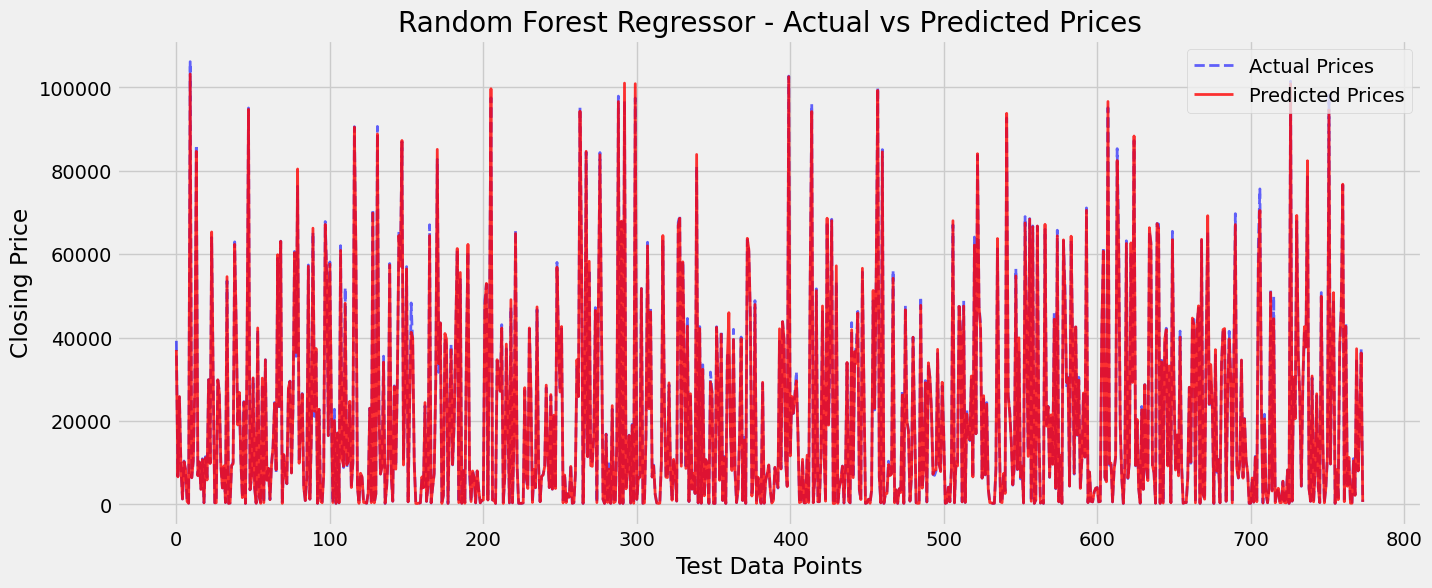

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y_test_inv, label='Actual Prices', color='blue',linewidth=2, alpha=0.6, linestyle='--')
plt.plot(predictions_inv, label='Predicted Prices', color='red',linewidth=2, alpha=0.8, linestyle='-')
plt.title('Random Forest Regressor - Actual vs Predicted Prices')
plt.xlabel('Test Data Points')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

LSTM

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_price[['Close']].dropna())

x_data = []
y_data = []
base_days = 100
for i in range(base_days, len(scaled_data)):
    x_data.append(scaled_data[i-base_days: i])
    y_data.append(scaled_data[i])

x_data = np.array(x_data)
y_data = np.array(y_data)

train_size = int(len(x_data) * 0.8)
x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

In [ ]:
model = Sequential([
    Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(base_days, 1))),
    Dropout(0.2),
    LSTM(units=100, return_sequences=True),
    Dropout(0.2),
    LSTM(units=100),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adamax', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 46s 360ms/step - loss: 0.0052 - val_loss: 0.0019
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 43s 384ms/step - loss: 7.5851e-04 - val_loss: 0.0012
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 40s 370ms/step - loss: 5.3654e-04 - val_loss: 0.0019
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - loss: 5.0095e-04 - val_loss: 0.0020
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 40s 357ms/step - loss: 4.5332e-04 - val_loss: 8.2349e-04


In [ ]:
y_pred = model.predict(x_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step


In [ ]:
lstm_mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
lstm_mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error (MAE): {lstm_mae}")
print(f"Mean Squared Error (MSE): {lstm_mse}")
print(f"Root Mean Squared Error (RMSE): {lstm_rmse}")
print(f'R2 Score: {lstm_r2}')

Mean Absolute Error (MAE): 2348.7604235742706
Mean Squared Error (MSE): 9247147.4964283
Root Mean Squared Error (RMSE): 3040.9122802916067
R2 Score: 0.9843036104838023


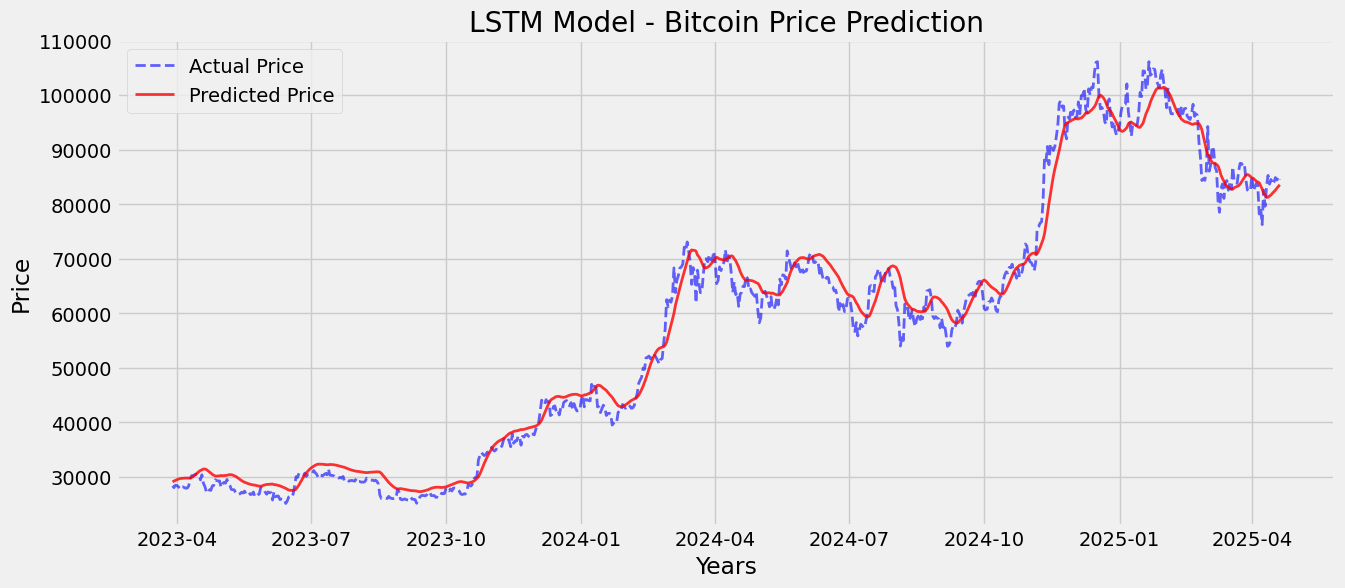

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(closing_price.index[train_size+base_days:], y_test_rescaled, label="Actual Price", color='blue',linestyle="--",linewidth=2, alpha=0.6)
plt.plot(closing_price.index[train_size+base_days:], y_pred_rescaled, label="Predicted Price", color='red',linewidth=2, alpha=0.8)
plt.xlabel("Years")
plt.ylabel("Price")
plt.title("LSTM Model - Bitcoin Price Prediction")
plt.legend()
plt.show()

hybrid model

In [ ]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(closing_price[['Close', 'MA_100', 'MA_365']])

X_rfr = scaled_data[:, 1:]
y_rfr = scaled_data[:, 0]
X_train_rfr, X_test_rfr, y_train_rfr, y_test_rfr = train_test_split(X_rfr, y_rfr, test_size=0.2, random_state=42)

rfr_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rfr_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rfr_model, param_grid=rfr_param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_rfr, y_train_rfr)
rfr_model = grid_search.best_estimator_

rfr_model.fit(X_train_rfr, y_train_rfr)


base_days = 100
X_lstm, y_lstm = [], []
scaled_close = scaler.fit_transform(closing_price[['Close']].dropna())

for i in range(base_days, len(scaled_close)):
    X_lstm.append(scaled_close[i - base_days: i])
    y_lstm.append(scaled_close[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]


model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(base_days, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer=Adamax(), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), callbacks=[early_stopping])

rfr_preds = rfr_model.predict(X_test_rfr)
lstm_preds = model.predict(X_test_lstm)

lstm_preds_rescaled = scaler.inverse_transform(lstm_preds.reshape(-1, 1))
rfr_preds_rescaled = scaler.inverse_transform(rfr_preds.reshape(-1, 1))

# Ensure same length for both predictions
min_len = min(len(lstm_preds_rescaled), len(rfr_preds_rescaled))
lstm_preds_rescaled = lstm_preds_rescaled[:min_len]
rfr_preds_rescaled = rfr_preds_rescaled[:min_len]

y_test_rescaled = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

hybrid_model = LinearRegression()
hybrid_model.fit(np.column_stack((lstm_preds_rescaled, rfr_preds_rescaled)), y_test_rescaled)

# Predict using learned weights
hybrid_preds = hybrid_model.predict(np.column_stack((lstm_preds_rescaled, rfr_preds_rescaled)))


print("Hybrid Model R2 Score:", r2_score(y_test_rescaled, hybrid_preds))


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - loss: 0.0067 - val_loss: 0.0039
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - loss: 9.8321e-04 - val_loss: 0.0041
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - loss: 9.8495e-04 - val_loss: 0.0027
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - loss: 9.1898e-04 - val_loss: 0.0037
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - loss: 8.6369e-04 - val_loss: 0.0025
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Hybrid Model R2 Score: 0.9751095243284882


In [ ]:
hy_mae = mean_absolute_error(y_test_rescaled, hybrid_preds)
hy_mse = mean_squared_error(y_test_rescaled, hybrid_preds)
hy_rmse = np.sqrt(hy_mse)
hy_r2 = r2_score(y_test_rescaled, hybrid_preds)
print(f"Hybrid Model MAE: {hy_mae}")
print(f"Hybrid Model MSE: {hy_mse}")
print(f"Hybrid Model RMSE: {hy_rmse}")
print(f"Hybrid Model R2 Score: {hy_r2}" )

Hybrid Model MAE: 2734.6792001474287
Hybrid Model MSE: 14663620.544916537
Hybrid Model RMSE: 3829.310714073296
Hybrid Model R2 Score: 0.9751095243284882


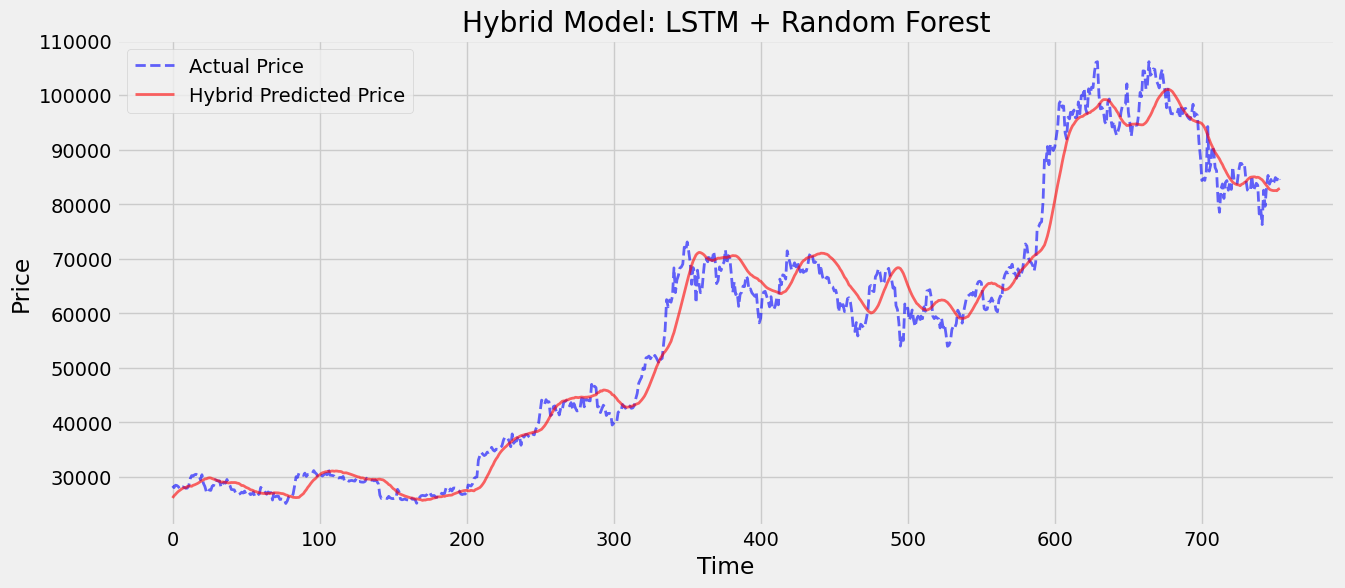

In [ ]:

plt.figure(figsize=(14,6))
plt.plot(y_test_rescaled, label='Actual Price', linestyle="--", color='blue',linewidth=2, alpha=0.6)
plt.plot(hybrid_preds, label='Hybrid Predicted Price', color='red',linewidth=2, alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Hybrid Model: LSTM + Random Forest')
plt.legend()
plt.show()

Meta model hybrid

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(closing_price[['Close', 'MA_100', 'MA_365']])

In [ ]:
X_rfr = scaled_data[:, 1:]
y_rfr = scaled_data[:, 0]
X_train_rfr, X_test_rfr, y_train_rfr, y_test_rfr = train_test_split(X_rfr, y_rfr, test_size=0.2, random_state=42)

rfr_model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42)
rfr_model.fit(X_train_rfr, y_train_rfr)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200, random_state=42)

In [ ]:

base_days = 100
X_lstm, y_lstm = [], []
scaled_close = scaler.fit_transform(closing_price[['Close']].dropna())

for i in range(base_days, len(scaled_close)):
    X_lstm.append(scaled_close[i - base_days: i])
    y_lstm.append(scaled_close[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(base_days, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer=Adamax(), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), callbacks=[early_stopping])

Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - loss: 0.0076 - val_loss: 0.0041
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - loss: 8.9819e-04 - val_loss: 0.0021
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - loss: 8.6631e-04 - val_loss: 0.0060


In [ ]:
rfr_preds = rfr_model.predict(X_test_rfr)
lstm_preds = model.predict(X_test_lstm)

lstm_preds_rescaled = scaler.inverse_transform(lstm_preds.reshape(-1, 1))
rfr_preds_rescaled = scaler.inverse_transform(rfr_preds.reshape(-1, 1))

# Ensure same length for both predictions
min_len = min(len(lstm_preds_rescaled), len(rfr_preds_rescaled))
lstm_preds_rescaled = lstm_preds_rescaled[:min_len]
rfr_preds_rescaled = rfr_preds_rescaled[:min_len]

y_test_rescaled = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


In [ ]:

meta_X_train = np.column_stack((lstm_preds_rescaled, rfr_preds_rescaled))
meta_y_train = y_test_rescaled[:min_len]

meta_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
meta_model.fit(meta_X_train, meta_y_train.ravel())

meta_preds = meta_model.predict(meta_X_train)

In [ ]:
meta_mae = mean_absolute_error(meta_y_train, meta_preds)
meta_mse = mean_squared_error(meta_y_train, meta_preds)
meta_rmse = np.sqrt(meta_mse)
meta_r2= r2_score(meta_y_train, meta_preds)
print(f"Meta Model MAE: {meta_mae}")
print(f"meta Model MSE: {meta_mse}")
print(f"Meta Model RMSE: {meta_rmse}")
print(f'R2 Score: {meta_r2}')

Meta Model MAE: 2030.657543406156
meta Model MSE: 7756178.907545647
Meta Model RMSE: 2784.991724861251
R2 Score: 0.9868344259311126


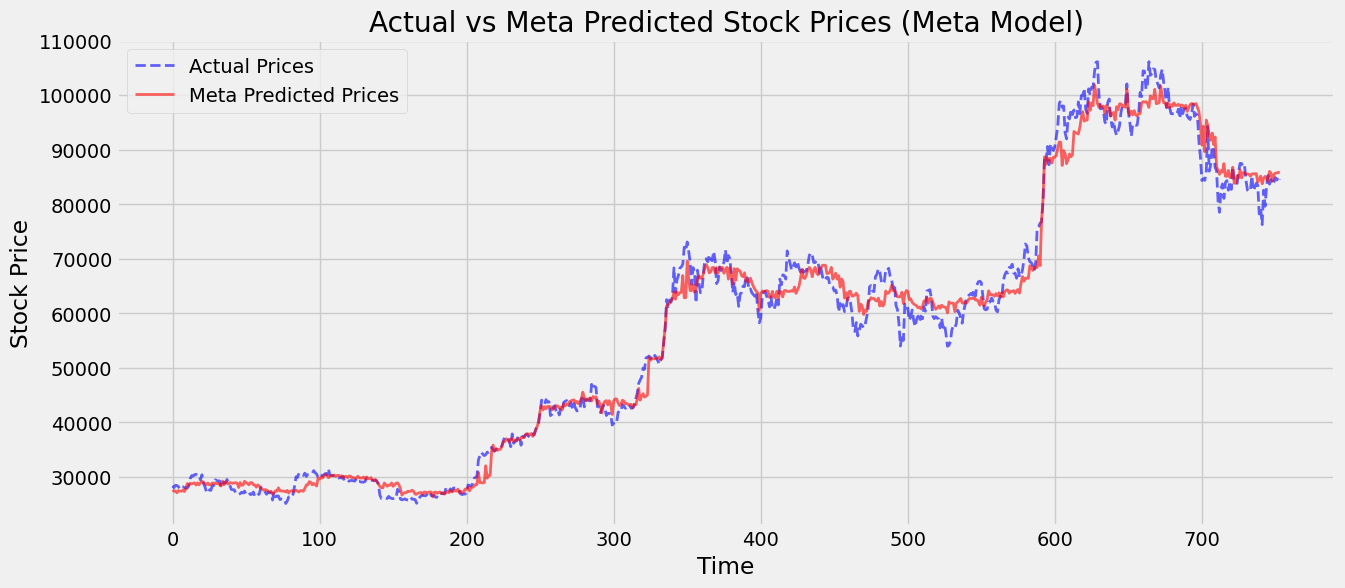

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(meta_y_train, label="Actual Prices", color="blue",linestyle="--",linewidth=2, alpha=0.6)
plt.plot(meta_preds, label="Meta Predicted Prices", color="red",linewidth=2, alpha=0.6)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Meta Predicted Stock Prices (Meta Model)")
plt.legend()
plt.show()

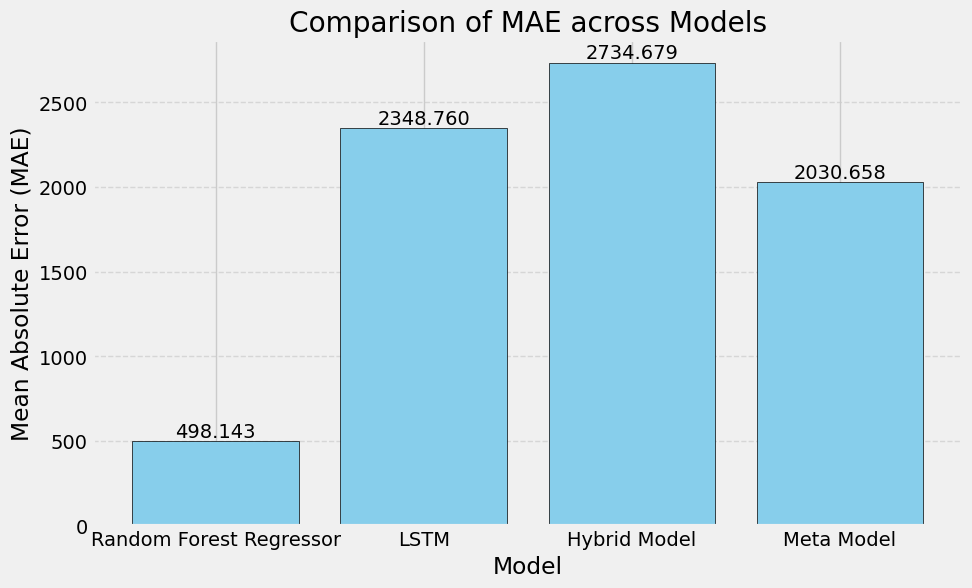

In [ ]:
model_names = ['Random Forest Regressor', 'LSTM', 'Hybrid Model', 'Meta Model']
mae_values = [rfr_mae,lstm_mae,hy_mae,meta_mae]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mae_values, color='skyblue', edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, f'{yval:.3f}', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of MAE across Models')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

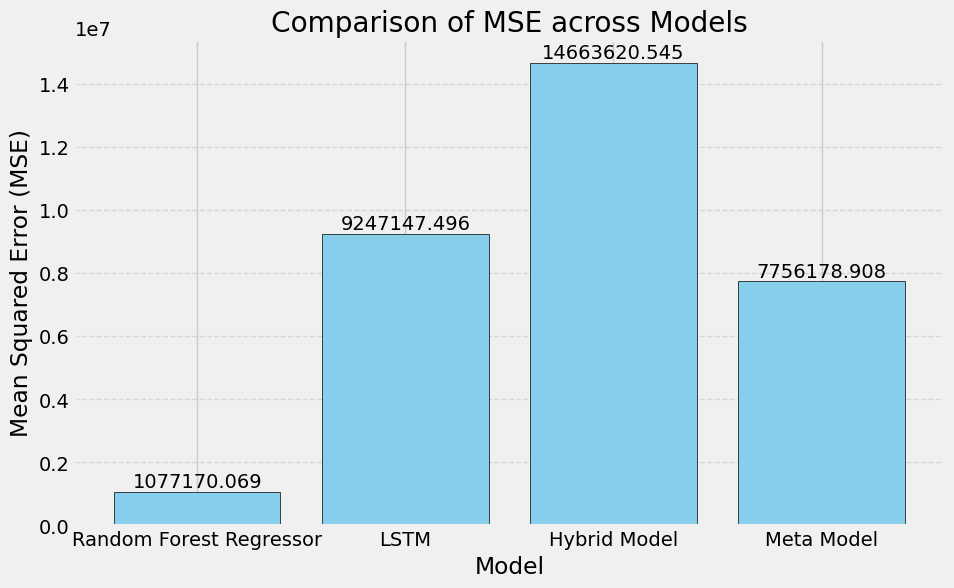

In [ ]:
model_names = ['Random Forest Regressor', 'LSTM', 'Hybrid Model', 'Meta Model']
mse_values = [rfr_mse,lstm_mse,hy_mse,meta_mse]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mse_values, color='skyblue', edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, f'{yval:.3f}', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE across Models')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


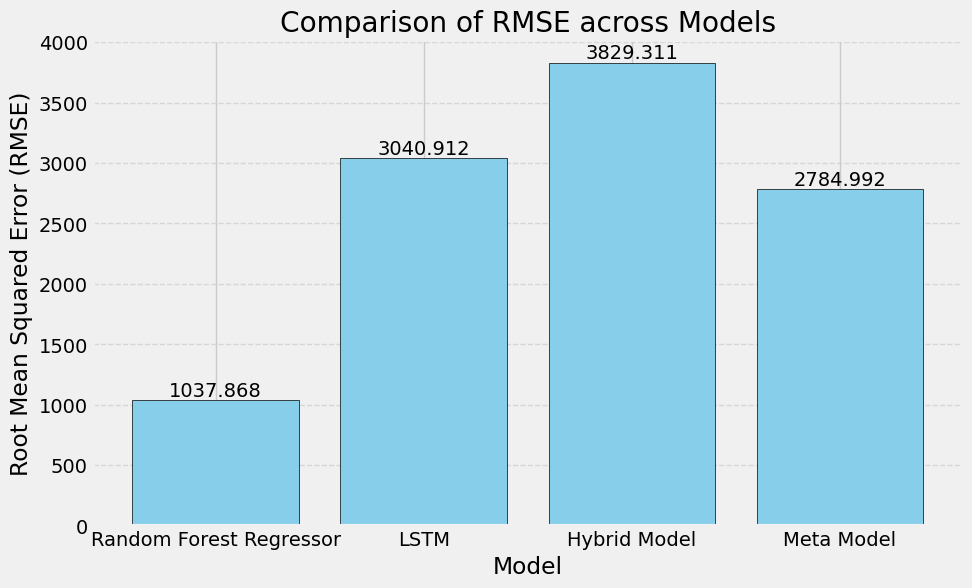

In [ ]:
model_names = ['Random Forest Regressor', 'LSTM', 'Hybrid Model', 'Meta Model']
rmse_values = [rfr_rmse,lstm_rmse,hy_rmse,meta_rmse]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, rmse_values, color='skyblue', edgecolor='black')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, f'{yval:.3f}', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of RMSE across Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


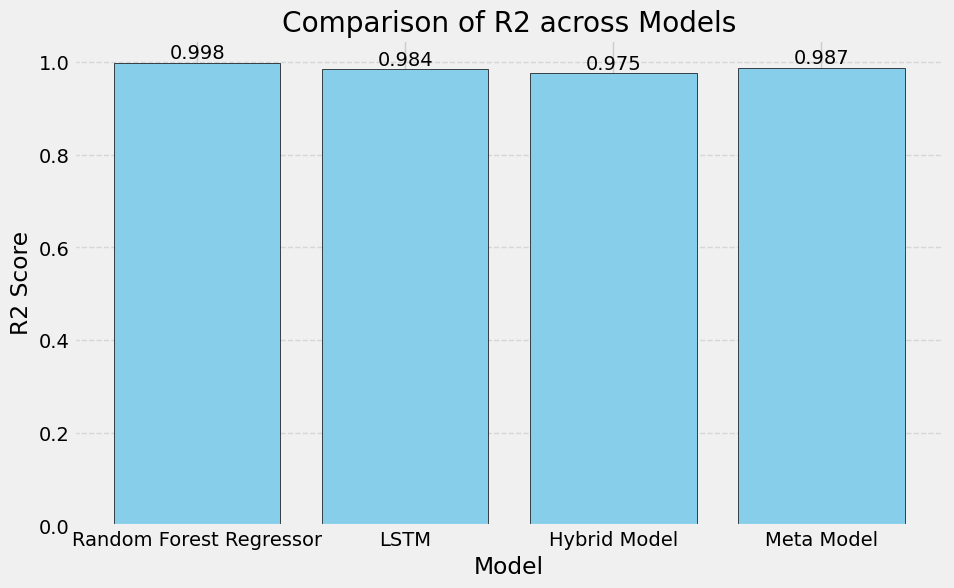

In [ ]:
model_names = ['Random Forest Regressor', 'LSTM', 'Hybrid Model', 'Meta Model']
r2_values = [rfr_r2,lstm_r2,hy_r2,meta_r2]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, r2_values, color='skyblue', edgecolor='black')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, f'{yval:.3f}', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Comparison of R2 across Models')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

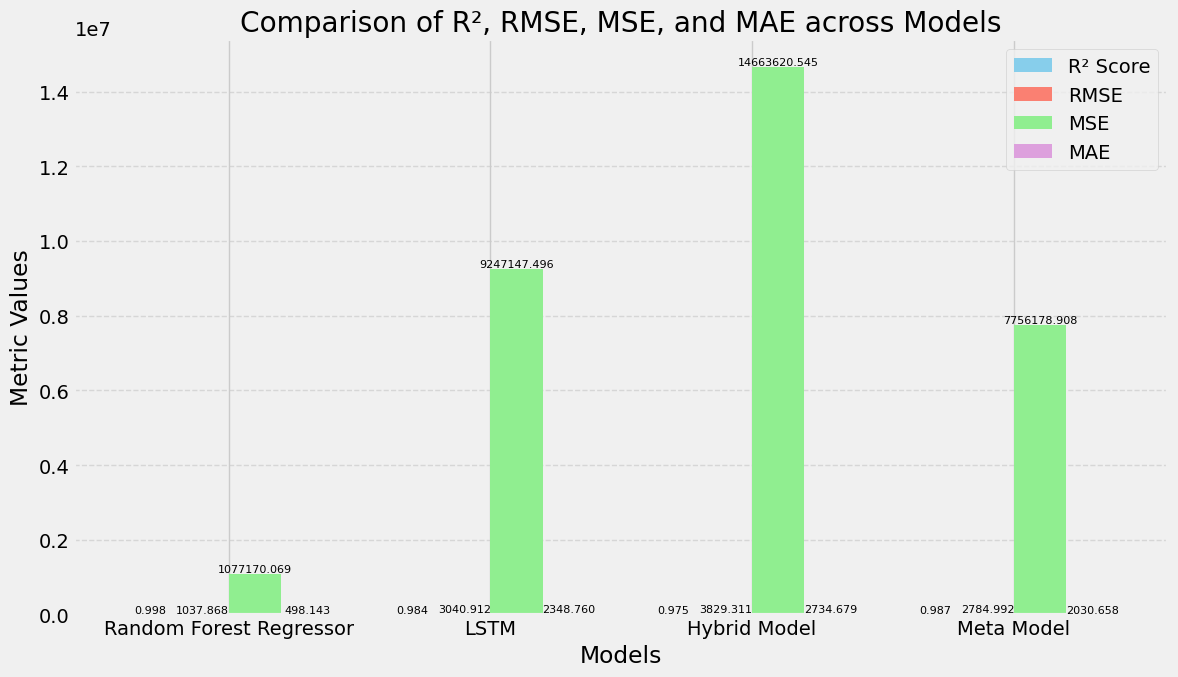

In [ ]:

model_names = ['Random Forest Regressor', 'LSTM', 'Hybrid Model', 'Meta Model']
r2_values = [rfr_r2, lstm_r2, hy_r2, meta_r2]
rmse_values = [rfr_rmse, lstm_rmse, hy_rmse, meta_rmse]
mse_values = [rfr_mse, lstm_mse, hy_mse, meta_mse]
mae_values = [rfr_mae, lstm_mae, hy_mae, meta_mae]

x = np.arange(len(model_names))  # the label locations
bar_width = 0.2

plt.figure(figsize=(12, 7))

bars1 = plt.bar(x - 1.5*bar_width, r2_values, bar_width, label='R² Score', color='skyblue')
bars2 = plt.bar(x - 0.5*bar_width, rmse_values, bar_width, label='RMSE', color='salmon')
bars3 = plt.bar(x + 0.5*bar_width, mse_values, bar_width, label='MSE', color='lightgreen')
bars4 = plt.bar(x + 1.5*bar_width, mae_values, bar_width, label='MAE', color='plum')

for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0005, f'{yval:.3f}', ha='center', va='bottom', fontsize=8)

plt.xlabel('Models')
plt.ylabel('Metric Values')
plt.title('Comparison of R², RMSE, MSE, and MAE across Models')
plt.xticks(x, model_names)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
